In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import trim_mean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import math
import seaborn as sns
sns.set_theme(style="whitegrid")

In [270]:
iris = pd.read_csv("IRIS.csv")

### Exploratory Data Analysis

In [271]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [272]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [273]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [274]:
iris.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [275]:
# Know the proportions of the feature class
iris["species"].value_counts() / len(iris)

species
Iris-setosa        0.333333
Iris-versicolor    0.333333
Iris-virginica     0.333333
Name: count, dtype: float64

##### It is a balanced dataset

In [276]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### Feature Engineering

##### Petals and Sepal ratios

In [277]:
iris_knn = pd.DataFrame()

iris_knn["sepal_ratio"] = iris["sepal_width"] / iris["sepal_length"]
iris_knn["petal_ratio"] = iris["petal_width"] / iris["petal_length"]
iris_knn["sepal_to_petal_ratio"] = iris_knn["sepal_ratio"] / iris_knn["petal_ratio"]
iris_knn["petal_to_sepal_ratio"] = iris_knn["petal_ratio"] / iris_knn["sepal_ratio"]
iris_knn["species"] = iris["species"]

label_encoder = LabelEncoder()

iris_knn["species_numeric"] = label_encoder.fit_transform(iris["species"]) 

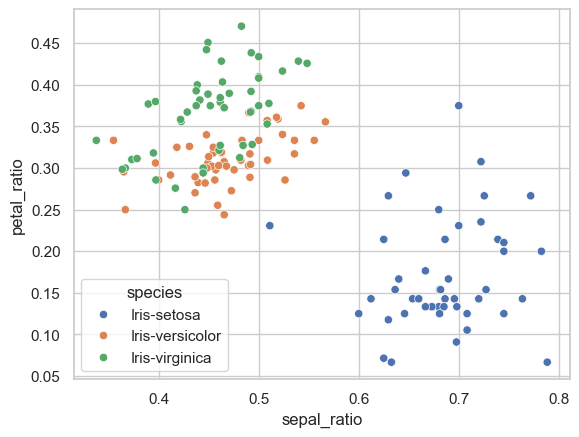

In [278]:
sns.scatterplot(x=iris_knn["sepal_ratio"], y=iris_knn["petal_ratio"], hue=iris_knn["species"])
plt.show()

sepal_ratio


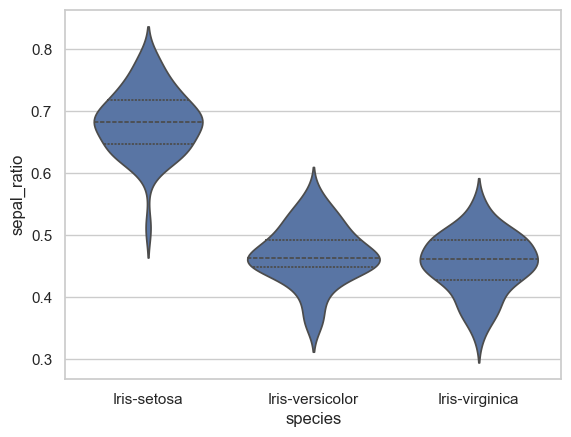

petal_ratio


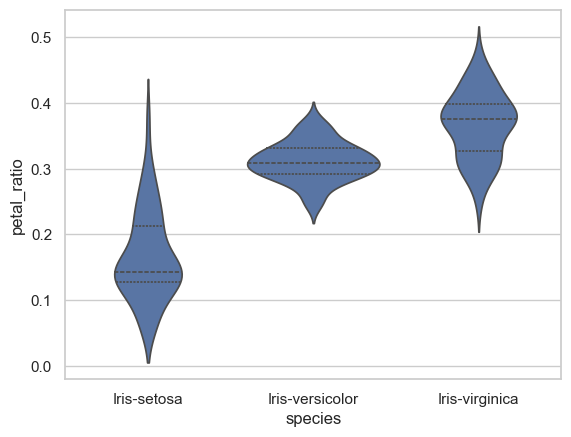

sepal_to_petal_ratio


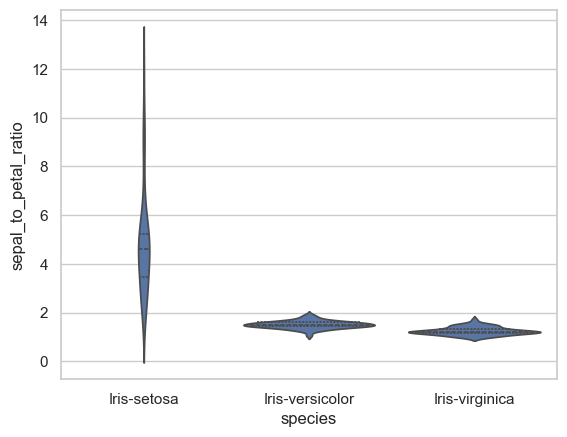

petal_to_sepal_ratio


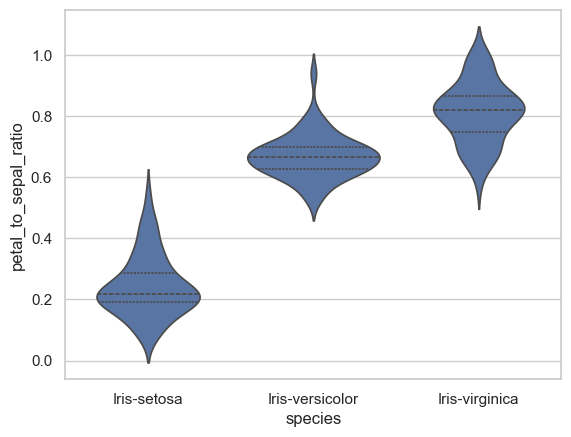

In [279]:
# Violin plot to see how things vary for individual features
for column in iris_knn.drop(columns=["species", "species_numeric"], axis=1, inplace=False).columns:
    print(column)
    sns.violinplot(x="species", y=column,data=iris_knn, inner="quartile")
    plt.show()

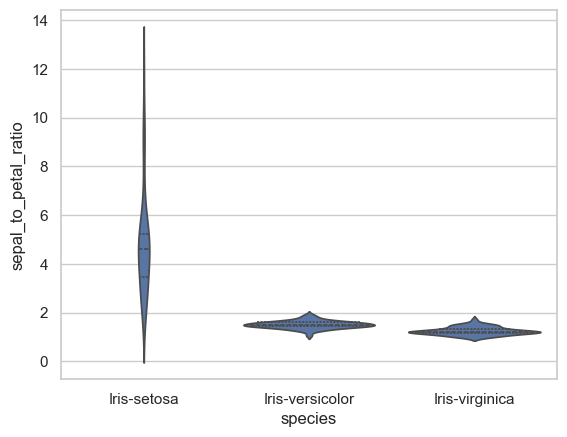

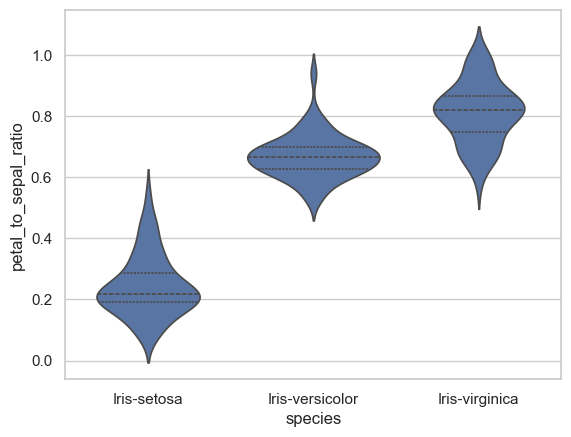

In [280]:
sns.violinplot(x="species", y="sepal_to_petal_ratio", data=iris_knn, inner="quartile")
plt.show()
# Petal To sepal Ratio looks good
sns.violinplot(x="species", y="petal_to_sepal_ratio", data=iris_knn, inner="quartile")
plt.show()

In [281]:
# I shall use the petal to sepal ratio for classification
iris_knn.drop(["petal_ratio", "sepal_ratio", "sepal_to_petal_ratio", "species"], axis=1, inplace=True)

# Splitting training and testing data
X = iris_knn.drop(["species_numeric"], axis=1)
y = iris_knn["species_numeric"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.7, shuffle=True,stratify=y ,random_state=1)

In [282]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
# Cross Validation to determine the best k value
k_values = []
max_knn = int((iris.shape[0])/(len(iris["species"].unique())))
results = []

scaler = StandardScaler()
test_X = scaler.fit_transform(X)

for i in range(1, max_knn):
    k_values.append(i)
    test_knn = KNeighborsClassifier(n_neighbors=i)
    test_score = cross_val_score(test_knn, test_X, y, cv=5)
    results.append(np.mean(test_score))

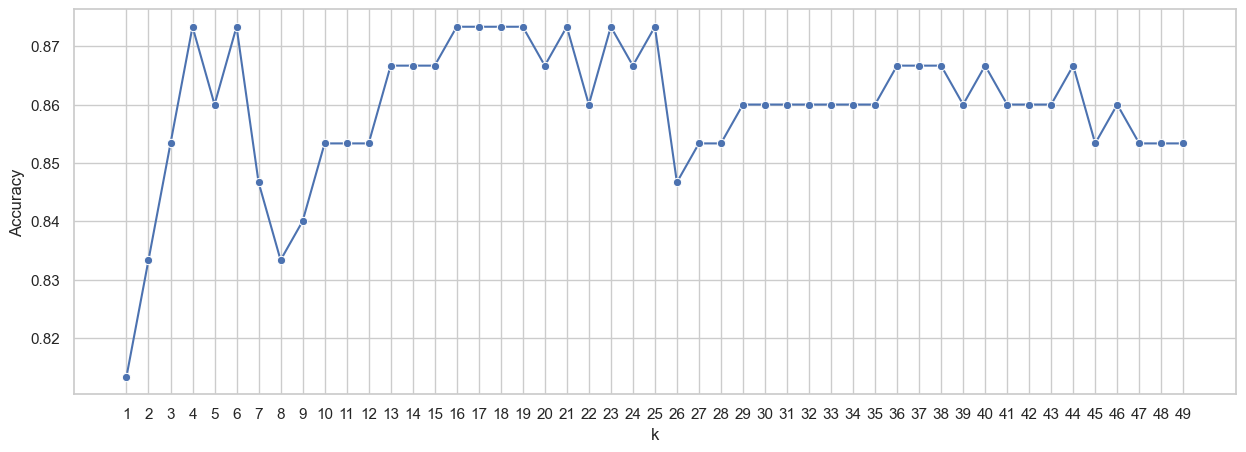

In [283]:
# Plotting the test scores against the possible k values to determine the best k value
plt.figure(figsize=(15, 5))
sns.lineplot(x = k_values, y = results, marker ="o")
plt.xlabel("k")
plt.ylabel("Accuracy")
# Setting ticks and step size on the x-axis
plt.xticks(range(min(k_values), max(k_values) + 1, 1))
plt.show()

##### I choose my k value as 4 

In [284]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
report = classification_report(y_true=y_test, y_pred=y_pred)
print("Accuracy:", round(accuracy, ndigits=3))
print(report)

Accuracy: 0.857
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       0.74      0.89      0.81        35
           2       0.86      0.71      0.78        35

    accuracy                           0.86       105
   macro avg       0.87      0.86      0.86       105
weighted avg       0.87      0.86      0.86       105



##### A thing to note is that Iris Setosa is easily classified, the other two species are close to each other but still relevantly easier to classify